# Import necessary libraries

In [ ]:
import os
import numpy as np
from PIL import Image
import pandas as pd

from skimage.metrics import structural_similarity as ssim

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.image import ssim_multiscale
from tensorflow.nn import relu,depth_to_space
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, Add, Lambda,UpSampling2D, Dense

import matplotlib.pyplot as plt

2024-11-11 19:55:57.315963: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 19:55:57.318545: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 19:55:57.380839: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 19:55:57.408078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731351357.458043   71000 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731351357.46

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Train_Loss', 'Train_PSNR', 'Train_SSIM', 
                                   'Val_Loss', 'Val_PSNR', 'Val_SSIM'])

# RDN model

In [2]:
lr_dir = './data/DIV2K_train_LR_bicubic_X4_extracted/DIV2K_train_LR_bicubic'
hr_dir = './data/DIV2K_train_HR_extracted'
test_lr_dir = './data/DIV2K_valid_LR_bicubic_X4_extracted/DIV2K_valid_LR_bicubic'
test_hr_dir = './data/DIV2K_valid_HR_extracted'

In [4]:
batch_size = 1

hrdatagen = ImageDataGenerator(rescale=1./255)
hrt = hrdatagen.flow_from_directory(
    directory=hr_dir, 
    target_size=(2040,2040), 
    class_mode=None,
    shuffle=False,
    batch_size=batch_size,
)

hrvdatagen = ImageDataGenerator(rescale=1./255)
hrv = hrvdatagen.flow_from_directory(
    directory=test_hr_dir,  
    target_size=(2040, 2040),  
    class_mode=None,  
    shuffle=False,
    batch_size=batch_size,
)

lrdatagen = ImageDataGenerator(rescale=1./255)
lrt = lrdatagen.flow_from_directory(
    directory=lr_dir, 
    target_size=(510, 510), 
    class_mode=None,
    shuffle=False,
    batch_size=batch_size,
)

lrvdatagen = ImageDataGenerator(rescale=1./255,)
lrv = lrvdatagen.flow_from_directory(
    directory=test_lr_dir,  
    target_size=(510, 510),  
    class_mode=None,  
    shuffle=False,
    batch_size=batch_size,
)

Found 800 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [3]:
def RDB(input_layer, num_layers, growth_rate):

    layer_outputs = [input_layer]
    for _ in range(num_layers):
        conv_output = tf.keras.layers.Conv2D(filters=growth_rate, kernel_size=(3, 3), padding='same', activation='relu')(layer_outputs[-1])
        concat_output = tf.keras.layers.Concatenate(axis=-1)([layer_outputs[-1], conv_output])
        layer_outputs.append(concat_output)
    rdb_output = tf.keras.layers.Concatenate(axis=-1)([layer_outputs[0],layer_outputs[-1]])
    rdb_output= tf.keras.layers.Conv2D(filters=64,kernel_size=(1,1),padding="same",activation="relu")(rdb_output)
    return rdb_output

def RDN(input_shape, num_rdb_blocks, num_layers_per_block, growth_rate):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    SFE1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    SFE2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(SFE1)

    outputs = [SFE1]
    rdb_outputs=[RDB(SFE1, num_layers_per_block, growth_rate)]
    for _ in range(num_rdb_blocks-1):
        output = RDB(rdb_outputs[-1], num_layers_per_block, growth_rate)
        rdb_outputs.append(output)
    
    concat_rdb_outputs = tf.keras.layers.Concatenate(axis=-1)(rdb_outputs)
    rdb_output = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu')(concat_rdb_outputs)
    outputs.append(rdb_output)
    
    concat=tf.keras.layers.Concatenate(axis=-1)(outputs)
    grl=tf.keras.layers.Conv2D(kernel_size=(3,3),filters=64,padding="same",activation="relu")(concat)
    
    upsampled_output = grl
    for _ in range(2):  
        upsampled_output = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(upsampled_output)
    
    output_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')(upsampled_output)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [5]:
class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, target_gen):
        self.gen1 = input_gen
        self.gen2 = target_gen
        assert len(input_gen) == len(target_gen)
    def __len__(self):
        return len(self.gen1)
    def __getitem__(self, i):
        x = self.gen1[i]
        y = self.gen2[i]

        return x, y

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()

In [6]:
training=JoinedGen(lrt, hrt)
validation=JoinedGen(lrv, hrv)

# Create the model

In [7]:
input_shape = (510,510, 3)
# number of RDB blocks
num_rdb_blocks = 4
num_layers_per_block = 3
# I would have prefered it to be 32 but 16 is less computationally expensive
growth_rate = 16

In [8]:
rdn_model = RDN(input_shape, num_rdb_blocks, num_layers_per_block, growth_rate)
rdn_model.summary()

2024-11-11 19:55:59.136987: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 510, 510,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 510, 510,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 510, 510,  │      4,624 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 510, 510,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 48)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 510, 510,  │      6,928 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 510, 510,  │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 510, 510,  │      9,232 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 510, 510,  │          0 │ concatenate_1[0]… │
│ (Concatenate)       │ 80)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 510, 510,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 112)              │            │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 510, 510,  │      7,232 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 510, 510,  │      9,232 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 510, 510,  │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 80)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 510, 510,  │     11,536 │ concatenate_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 510, 510,  │          0 │ concatenate_4[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 510, 510,  │     13,840 │ concatenate_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 510, 510,  │          0 │ concatenate_5[0]… │
│ (Concatenate)       │ 112)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 510, 510,  │          0 │ conv2d_5[0][0], 

 Total params: 314,115 (1.20 MB)

 Trainable params: 314,115 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

# Define loss and compile the model

In [9]:
def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32) 
    
    # compute SSIM index for each image
    ssim_loss_per_image = tf.image.ssim(y_true, y_pred, max_val=1.0)

    # compute mean SSIM loss across all images in the batch
    mean_ssim_loss = 1.0 - tf.reduce_mean(ssim_loss_per_image)
    return mean_ssim_loss


def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ssim_index_per_image = tf.image.ssim(y_true, y_pred, max_val=1.0)
    mean_ssim_index = tf.reduce_mean(ssim_index_per_image)
    return mean_ssim_index


def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # PSNR formula: PSNR = 20 * log10(max_pixel) - 10 * log10(MSE)
    # assuming images are normalized to [0, 1] range
    max_pixel = 1.0
    psnr = 20 * tf.math.log(max_pixel) / tf.math.log(10.0) - 10 * tf.math.log(mse) / tf.math.log(10.0)
    return psnr


# SSIM loss

In [10]:
rdn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=ssim_loss, metrics=[ssim_metric, psnr_metric])

In [ ]:
history = rdn_model.fit(training, epochs=5, validation_data=validation, batch_size=batch_size, verbose=1)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.5407 - psnr_metric: 11.3177 - ssim_metric: 0.4593

/home/ansamz/envs/super_res/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


800/800 ━━━━━━━━━━━━━━━━━━━━ 1444s 2s/step - loss: 0.5407 - psnr_metric: 11.3180 - ssim_metric: 0.4593 - val_loss: 0.4753 - val_psnr_metric: 11.9033 - val_ssim_metric: 0.5247
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1433s 2s/step - loss: 0.4485 - psnr_metric: 12.1986 - ssim_metric: 0.5515 - val_loss: 0.3879 - val_psnr_metric: 17.0307 - val_ssim_metric: 0.6121
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1441s 2s/step - loss: 0.3583 - psnr_metric: 18.1104 - ssim_metric: 0.6417 - val_loss: 0.3310 - val_psnr_metric: 18.9248 - val_ssim_metric: 0.6690
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1438s 2s/step - loss: 0.3201 - psnr_metric: 19.3070 - ssim_metric: 0.6799 - val_loss: 0.3176 - val_psnr_metric: 19.9260 - val_ssim_metric: 0.6824
Epoch 5/5
470/800 ━━━━━━━━━━━━━━━━━━━━ 9:24 2s/step - loss: 0.3106 - psnr_metric: 19.4384 - ssim_metric: 0.6894

In [ ]:
metrics = {
    'Model': 'RDN SSIM',
    'Train_Loss': history.history['loss'],
    'Train_PSNR': history.history['psnr_metric'],
    'Train_SSIM': history.history['ssim_metric'], 
    'Val_Loss': history.history['val_loss'],
    'Val_PSNR': history.history['val_psnr_metric'],
    'Val_SSIM': history.history['val_ssim_metric']
}

results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)
results_df.to_csv('model_results.csv')

In [ ]:
rdn_model.save('./models_save_states/RDN_ssim.keras')

In [ ]:
loss = metrics['Train_Loss']
psnr = metrics['Train_PSNR']
ssim = metrics['Train_SSIM']
val_loss = metrics['Val_Loss']
val_psnr = metrics['Val_PSNR']
val_ssim = metrics['Val_SSIM']

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(psnr, label='Training PSNR')
plt.plot(val_psnr, label='Validation PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Training and Validation PSNR')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ssim, label='Training SSIM')
plt.plot(val_ssim, label='Validation SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('Training and Validation SSIM')
plt.legend()
plt.tight_layout()
plt.savefig(f'./img/RDN_SSIM_output.png')
plt.show()

# MSE loss

In [ ]:
rdn_model2 = RDN(input_shape, num_rdb_blocks, num_layers_per_block, growth_rate)

In [ ]:
rdn_model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="mse", metrics=[ssim_metric, psnr_metric])

In [ ]:
history2 = rdn_model2.fit(training, epochs=5,validation_data =validation,batch_size=batch_size, verbose=1)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 295s 355ms/step - loss: 0.0096 - psnr_metric: 21.1798 - ssim_metric: 0.7768 - val_loss: 0.0084 - val_psnr_metric: 21.7971 - val_ssim_metric: 0.7673
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 283s 353ms/step - loss: 0.0087 - psnr_metric: 21.6846 - ssim_metric: 0.7732 - val_loss: 0.0080 - val_psnr_metric: 22.0339 - val_ssim_metric: 0.7663
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 283s 353ms/step - loss: 0.0077 - psnr_metric: 22.1194 - ssim_metric: 0.7597 - val_loss: 0.0066 - val_psnr_metric: 22.7926 - val_ssim_metric: 0.7373
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 283s 353ms/step - loss: 0.0066 - psnr_metric: 22.8768 - ssim_metric: 0.7323 - val_loss: 0.0056 - val_psnr_metric: 23.4490 - val_ssim_metric: 0.7337
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 283s 353ms/step - loss: 0.0053 - psnr_metric: 23.6997 - ssim_metric: 0.7390 - val_loss: 0.0046 - val_psnr_metric: 24.2988 - val_ssim_metric: 0.7498
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 283s 352ms/step - lo

In [ ]:
metrics2 = {
    'Model': 'RDN SSIM',
    'Train_Loss': history2.history['loss'],
    'Train_PSNR': history2.history['psnr_metric'],
    'Train_SSIM': history2.history['ssim_metric'], 
    'Val_Loss': history2.history['val_loss'],
    'Val_PSNR': history2.history['val_psnr_metric'],
    'Val_SSIM': history2.history['val_ssim_metric']
}

results_df = pd.concat([results_df, pd.DataFrame(metrics2)], ignore_index=True)
results_df.to_csv('model_results.csv')

rdn_model2.save('./models_save_states/RDN_mse.keras')

In [ ]:
loss = metrics2['Train_Loss']
psnr = metrics2['Train_PSNR']
ssim = metrics2['Train_SSIM']
val_loss = metrics2['Val_Loss']
val_psnr = metrics2['Val_PSNR']
val_ssim = metrics2['Val_SSIM']

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(psnr, label='Training PSNR')
plt.plot(val_psnr, label='Validation PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Training and Validation PSNR')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ssim, label='Training SSIM')
plt.plot(val_ssim, label='Validation SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('Training and Validation SSIM')
plt.legend()
plt.tight_layout()
plt.savefig(f'./img/RDN_mse_output.png')
plt.show()

# Show predicted images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


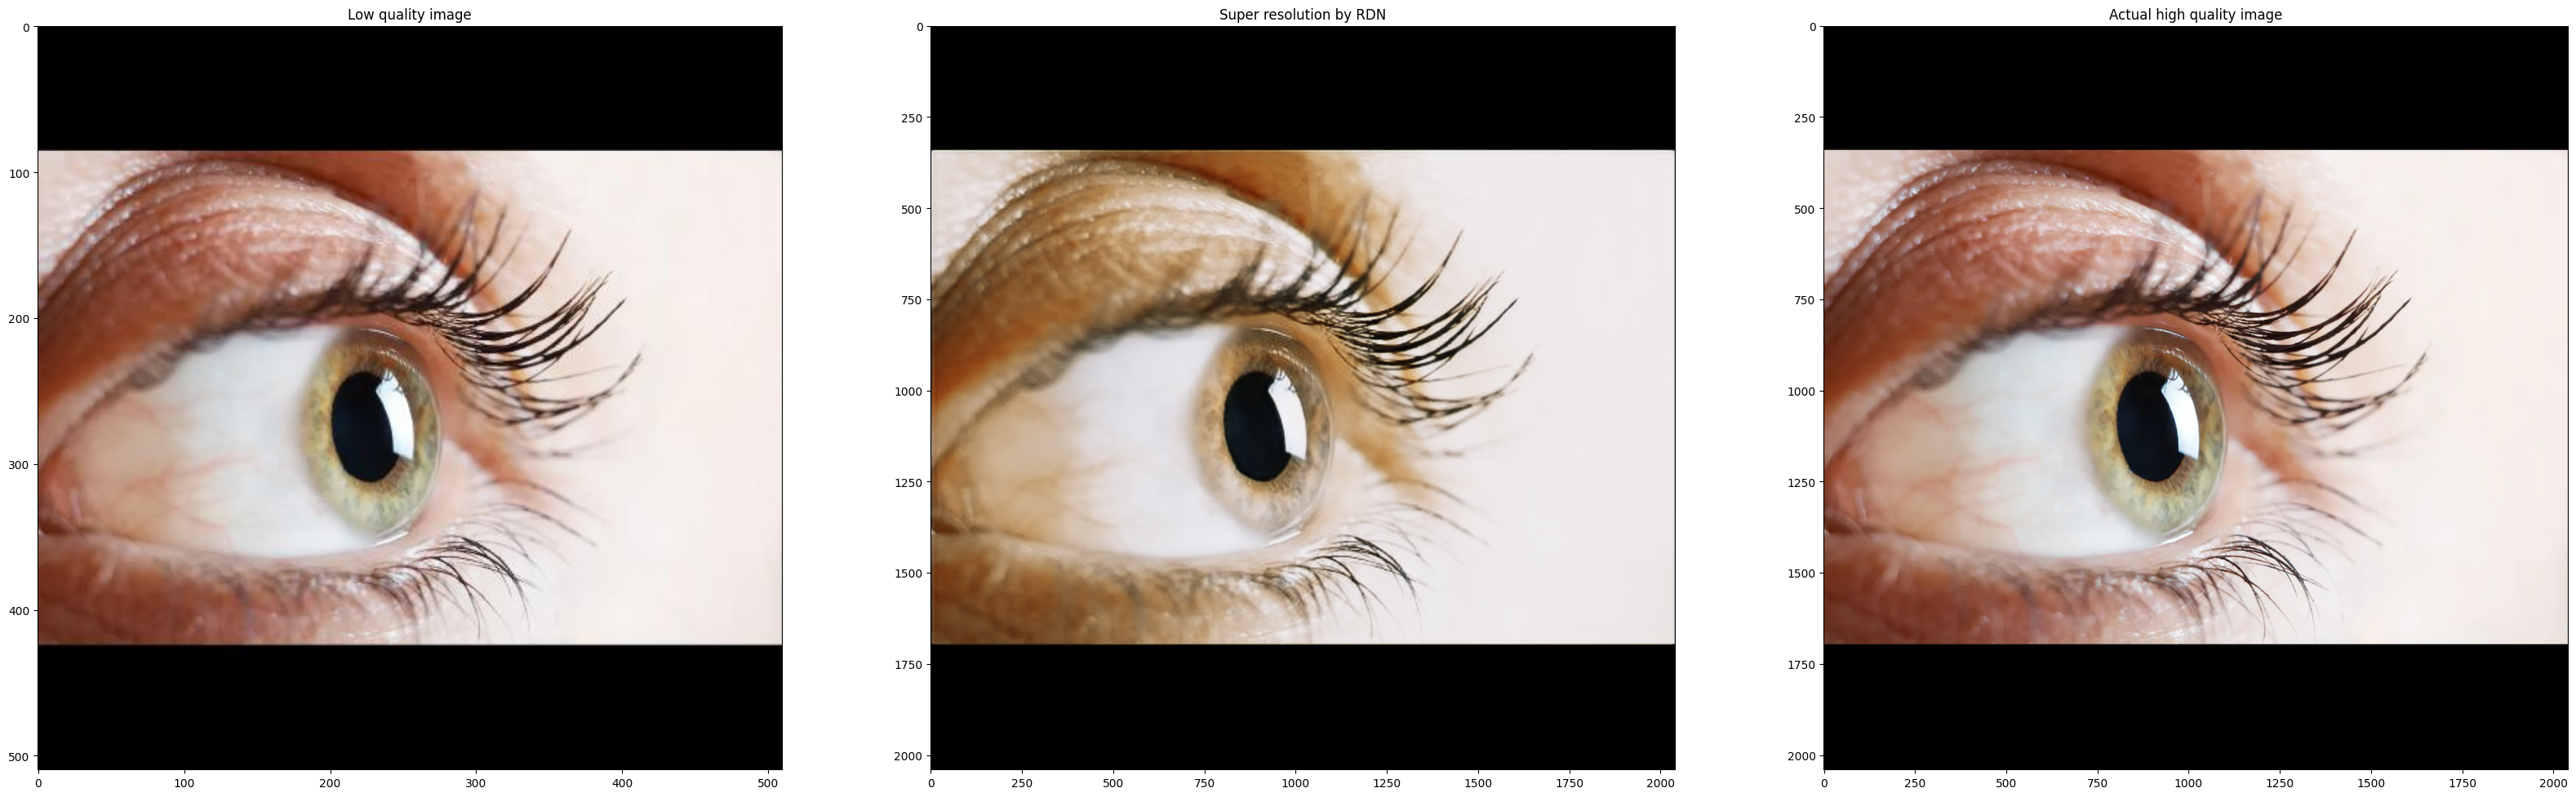

In [ ]:
lr_img = validation[8][0][0]
prediction_model1 = rdn_model.predict(validation[8][0])[0]
hr_img = validation[8][1][0]

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(lr_img)
plt.title("Low quality image")

plt.subplot(1,3,2)
plt.imshow(prediction_model1)
plt.title("Super resolution by RDN SSIM")

plt.subplot(1,3,3)
plt.imshow(hr_img)
plt.title("Actual high quality image")

plt.show()

In [ ]:
prediction_model2 = rdn_model2.predict(validation[8][0])[0]

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(lr_img)
plt.title("Low quality image")

plt.subplot(1,3,2)
plt.imshow(prediction_model2)
plt.title("Super resolution by RDN SSIM")

plt.subplot(1,3,3)
plt.imshow(hr_img)
plt.title("Actual high quality image")

plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step
